In [12]:
from seq2seq import *
import tltk, jiwer
import pandas as pd

In [13]:
### load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()

### additional dict data
dic_x = open('data/dic_x.txt').read().splitlines()
dic_y = open('data/dic_y.txt').read().splitlines()

In [14]:
### Instantiation
data = Data()
data.set_train(train_x, train_y)
data.set_test(test_x, test_y)

### set dict data
data.set_train(dic_x, dic_y)

In [15]:
### build no attention model
seq2seq1 = Seq2Seq(data, attention=False)
seq2seq1.build(show_summary=True)

### build attention model
seq2seq2 = Seq2Seq(data, attention=True)
seq2seq2.build(show_summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enc_Input (InputLayer)         [(None, 55)]         0           []                               
                                                                                                  
 Enc_Embedding (Embedding)      (None, 55, 256)      24064       ['Enc_Input[0][0]']              
                                                                                                  
 Dec_Input (InputLayer)         [(None, 69)]         0           []                               
                                                                                                  
 BiDir (Bidirectional)          [(None, 256),        394240      ['Enc_Embedding[0][0]']          
                                 (None, 128),                                                 

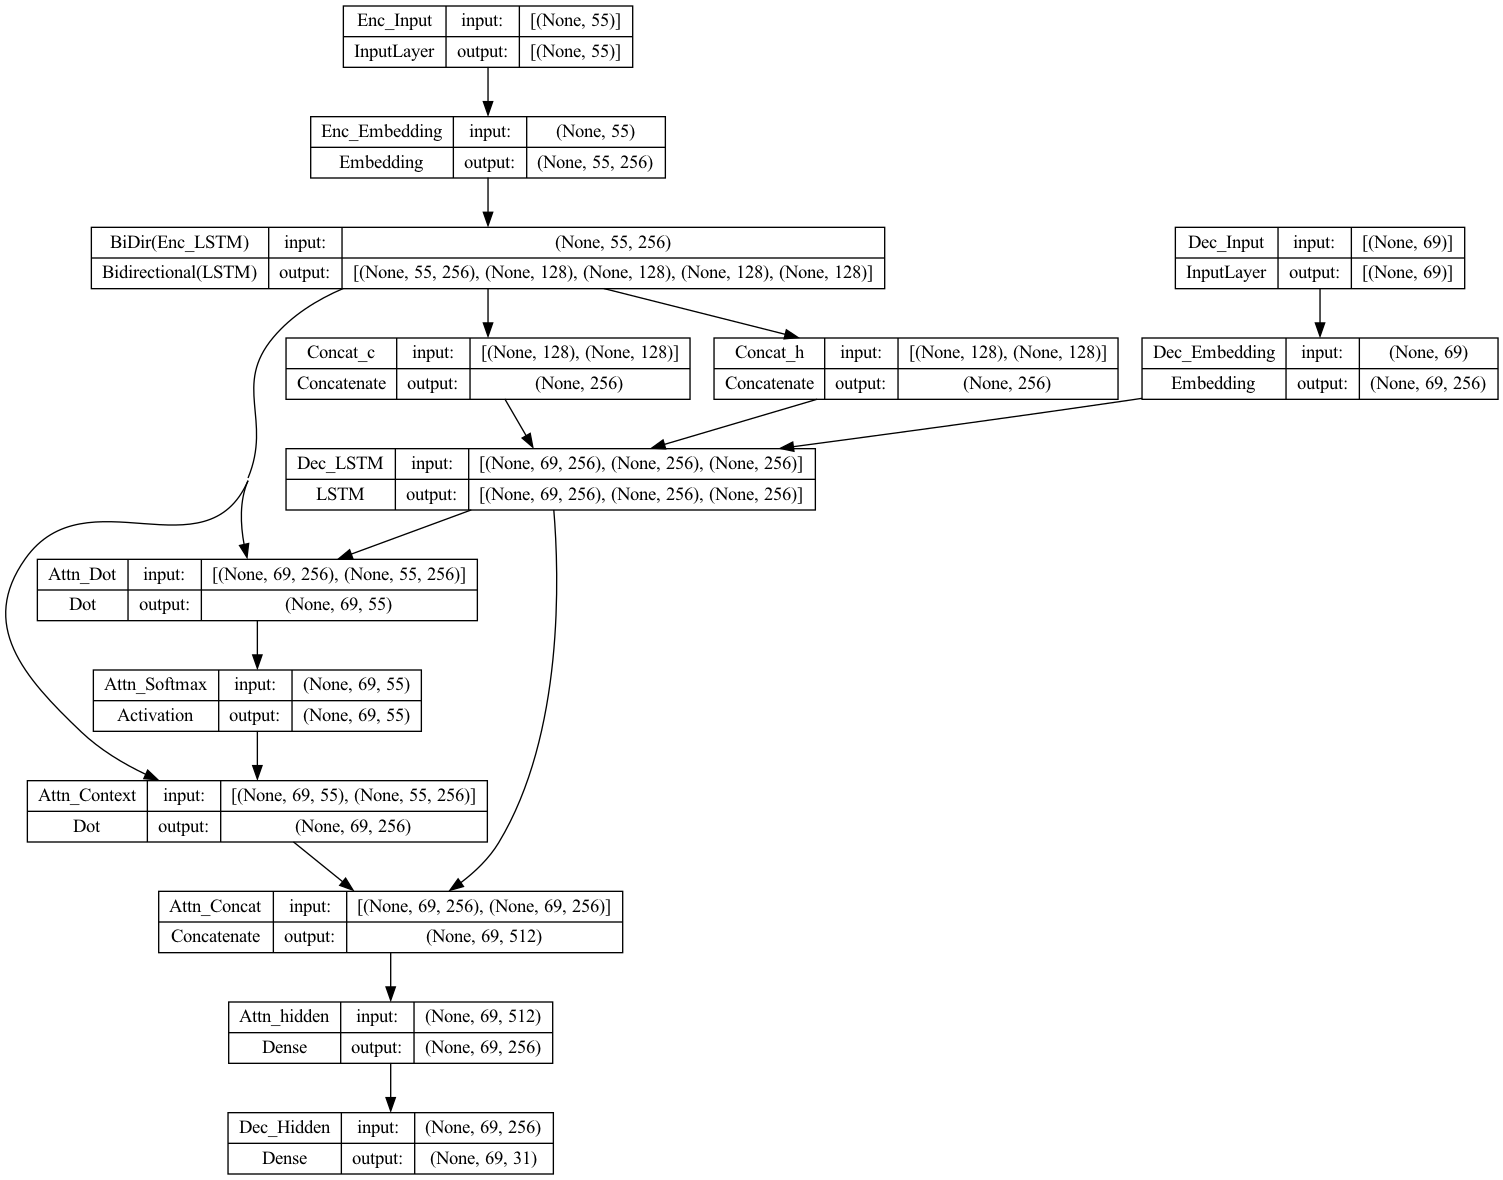

In [16]:
seq2seq2.show_model()

# train

Epoch 1/30
234/234 [==============================] - 191s 817ms/step - loss: 0.2295 - accuracy: 0.5028
Epoch 2/30
234/234 [==============================] - 194s 828ms/step - loss: 0.1214 - accuracy: 0.7300
Epoch 3/30
234/234 [==============================] - 193s 826ms/step - loss: 0.0785 - accuracy: 0.8229
Epoch 4/30
234/234 [==============================] - 193s 824ms/step - loss: 0.0584 - accuracy: 0.8686
Epoch 5/30
234/234 [==============================] - 194s 829ms/step - loss: 0.0462 - accuracy: 0.8953
Epoch 6/30
234/234 [==============================] - 191s 816ms/step - loss: 0.0378 - accuracy: 0.9146
Epoch 7/30
234/234 [==============================] - 202s 863ms/step - loss: 0.0318 - accuracy: 0.9283
Epoch 8/30
234/234 [==============================] - 194s 828ms/step - loss: 0.0270 - accuracy: 0.9389
Epoch 9/30
234/234 [==============================] - 191s 818ms/step - loss: 0.0234 - accuracy: 0.9472
Epoch 10/30
234/234 [==============================] - 186s 797m

KeyboardInterrupt: 

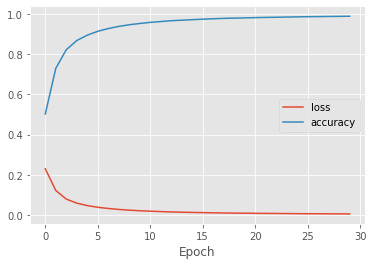

In [18]:
BATCHSIZE = 128
EPOCH = 30

seq2seq1.train(batch_size=BATCHSIZE, epoch=EPOCH, dev_split=0)
seq2seq2.train(batch_size=BATCHSIZE, epoch=EPOCH, dev_split=0)

# save/load weight

In [35]:
seq2seq1.model.save_weights('model_weight/dict_lstm/weight')
seq2seq2.model.save_weights('model_weight/dict_attn/weight')

#seq2seq1.model.load_weights('model_weight/dict_lstm/weight')
#seq2seq2.model.load_weights('model_weight/dict_attn/weight')

# evaluate model

In [36]:
### GREEDY SEARCH
pred1 = seq2seq1.predict(join_by='')
pred2 = seq2seq2.predict(join_by='')
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
df[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict.csv', index=False)

100%|██████████| 700/700 [04:15<00:00,  2.74it/s]


In [37]:
def evaluate(df):
    cols = df.columns
    gold_list = list(df.answer)
    tempdf = pd.DataFrame(index=['WER','CER macro', 'CER micro'])

    for col in cols:
        if col in ['answer', 'thai']:
            continue
        pred_list = list(df[col])
        WER = jiwer.wer(pred_list, gold_list)
        CERmacro = np.mean([jiwer.cer(p,g) for p,g in zip(pred_list, gold_list)])
        CERmicro = sum([jiwer.cer(p,g)*len(g) for p,g in zip(pred_list, gold_list)])/sum([len(g) for g in gold_list])
        tempdf[col] = [WER, CERmacro, CERmicro]
    return tempdf

evaluate(df)

,pred1,pred2,tltk
WER,0.138571,0.114286,0.098571
CER macro,0.031988,0.025425,0.013702
CER micro,0.032439,0.026567,0.012865


In [38]:
### BEAM SEARCH
pred1 = seq2seq1.predict(join_by='',is_beam=True,beam_return_all=False)
pred2 = seq2seq2.predict(join_by='',is_beam=True,beam_return_all=False)
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
df[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict_beam.csv', index=False)

evaluate(df)

100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


,pred1,pred2,tltk
WER,0.137143,0.111429,0.098571
CER macro,0.030688,0.025023,0.013702
CER micro,0.031266,0.026068,0.012865


### coding test

In [40]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

อรรถยา
['atthaya', 'attaya', 'anthaya']
attaya


In [31]:
i = np.random.randint(0,700)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

มะลิ
['mali', 'malit', 'mani']
mali


In [39]:
seq2seq3 = Seq2Seq(data, attention=False)
seq2seq3.build(show_summary=False)
seq2seq3.model.load_weights('model_weight/dict_lstm/weight')

In [40]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq3.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

จิราทิพย์
['chirathip', 'chiraphit', 'charithip']
chirathip


In [31]:
names = ["วิโรจน์","ภาวดี","ศุจิณัฐ","ธีราภรณ์","อรรถพล","ณัฏฐนันท์","พิทยาวัฒน์"]
df = pd.DataFrame(columns=["tltk","my model"])
for name in names:
    n = seq2seq1.predict_one(name, join_by="")
    t = tltk.th2roman(name).replace("<s/>","").replace(" ","").strip()
    df.loc[name] = [t,n]
df

,tltk,my model
วิโรจน์,wirot,wirot
ภาวดี,phawadi,phawadi
ศุจิณัฐ,suchinattha,suchinat
ธีราภรณ์,thiraphon,thiraphon
อรรถพล,atphon,atthaphon
ณัฏฐนันท์,natthanan,natthanan
พิทยาวัฒน์,phitthayawat,phitthayawat


In [32]:
names = ["พิทยาภรณ์","รติธรรมกุล","จันทร์เจ้าฉาย","สายสุวรรณ","อรุณมานะกุล","จิตวิริยนนท์","ธำรงรัตนฤทธิ์"]
df = pd.DataFrame(columns=["tltk","my model"])
for name in names:
    n = seq2seq1.predict_one(name, join_by="")
    t = tltk.th2roman(name).replace("<s/>","").replace(" ","").strip()
    df.loc[name] = [t,n]
df

,tltk,my model
พิทยาภรณ์,phitthayaphon,phitthayaphon
รติธรรมกุล,ratithamkun,ritthammakun
จันทร์เจ้าฉาย,chanchaochai,chanchotchao
สายสุวรรณ,saisuwan,saisuwan
อรุณมานะกุล,arunmanakun,arunamnukan
จิตวิริยนนท์,chitwiriyanon,chitwiyinon
ธำรงรัตนฤทธิ์,thamrongrattanarit,thamrangtrantrit


In [5]:
tltk.g2p_all?

Signature: tltk.g2p_all(inp)
Docstring: <no docstring>
File:      /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tltk/nlp.py
Type:      function
